In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import autograd
import autograd.numpy as np

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

## Create Data

In [6]:
def hamiltonian_fn(coords):
    q, p = np.split(coords,2)
    H = 3*(1-np.cos(q)) + p**2 # pendulum hamiltonian
    return H

def dynamics_fn(t, coords):
    dcoords = autograd.grad(hamiltonian_fn)(coords)
    dqdt, dpdt = np.split(dcoords,2)
    S = np.concatenate([dpdt, -dqdt], axis=-1)
    return S

def get_trajectory(t_span=[0,3], timescale=15, radius=None, y0=None, noise_std=0.1, **kwargs):
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0])))
    
    # get initial state
    if y0 is None:
        y0 = np.random.rand(2)*2.-1
    if radius is None:
        radius = np.random.rand() + 1.3 # sample a range of radii
    y0 = y0 / np.sqrt((y0**2).sum()) * radius ## set the appropriate radius

    spring_ivp = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10, **kwargs)
    q, p = spring_ivp['y'][0], spring_ivp['y'][1]
    dydt = [dynamics_fn(None, y) for y in spring_ivp['y'].T]
    dydt = np.stack(dydt).T
    dqdt, dpdt = np.split(dydt,2)
    
    # add noise
    q += np.random.randn(*q.shape)*noise_std
    p += np.random.randn(*p.shape)*noise_std
    return q, p, dqdt, dpdt, t_eval

def get_dataset(seed=0, samples=50, test_split=0.5, **kwargs):
    data = {'meta': locals()}

    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs = [], []
    for s in range(samples):
        x, y, dx, dy, t = get_trajectory(**kwargs)
        xs.append( np.stack( [x, y]).T )
        dxs.append( np.stack( [dx, dy]).T )
        
    data['x'] = np.concatenate(xs)
    data['dx'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

def get_field(xmin=-1.2, xmax=1.2, ymin=-1.2, ymax=1.2, gridsize=20):
    field = {'meta': locals()}

    # meshgrid to get vector field
    b, a = np.meshgrid(np.linspace(xmin, xmax, gridsize), np.linspace(ymin, ymax, gridsize))
    ys = np.stack([b.flatten(), a.flatten()])
    
    # get vector directions
    dydt = [dynamics_fn(None, y) for y in ys.T]
    dydt = np.stack(dydt).T

    field['x'] = ys.T
    field['dx'] = dydt.T
    return field

In [9]:
DPI = 300
FORMAT = 'pdf'
LINE_SEGMENTS = 10
ARROW_SCALE = 40
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'pend',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Plot Data

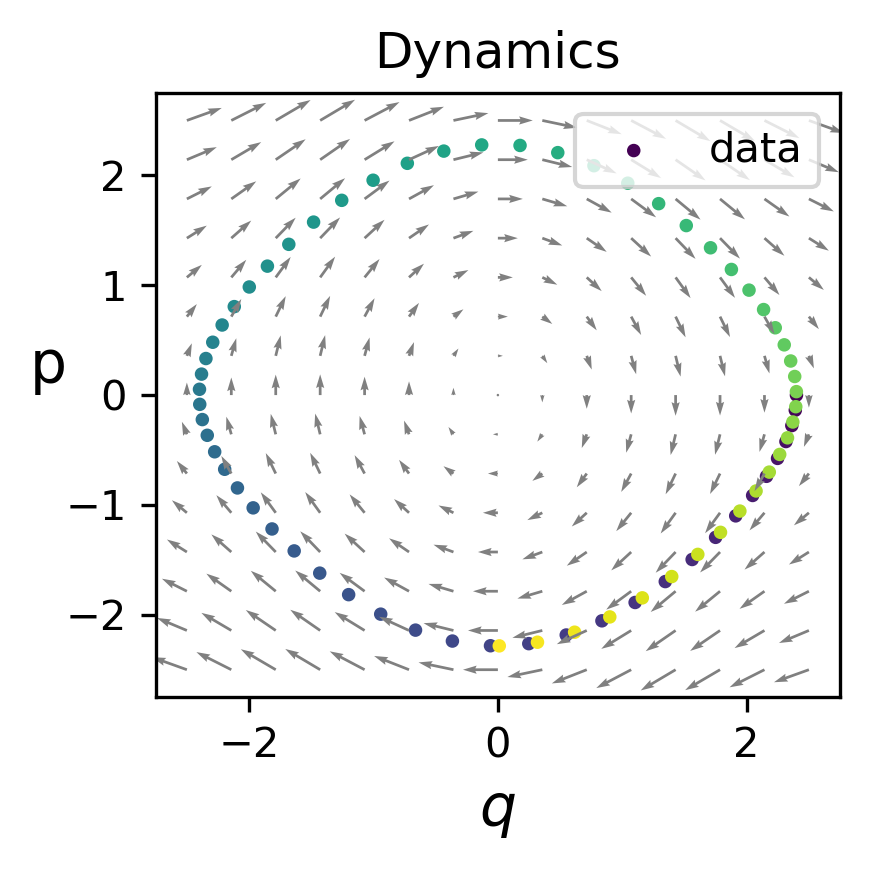

In [130]:
args = ObjectView(get_args())
# np.random.seed(args.seed)
R = 2.5
field = get_field(xmin=-R, xmax=R, ymin=-R, ymax=R, gridsize=15)
data = get_dataset()

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

x, y, dx, dy, t = get_trajectory(t_span=[0,5], radius=2.4, y0=np.array([2,0]), noise_std=0)
plt.scatter(x,y,c=t,s=5, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("p", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

plt.tight_layout() ; plt.show()

## Lern baseline Network

In [132]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.fc1 = nn.Linear(2, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 2)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [133]:
model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss = nn.MSELoss()

q_p = torch.stack([torch.tensor(x), torch.tensor(y)], dim=1)
dq_dp = torch.stack([torch.tensor(dx[0]), torch.tensor(dy[0])], dim=1) 

def train(model, optimizer, loss, x, dx, epochs):
    model.train()
    for step in range(epochs):
        optimizer.zero_grad()
        x_pred = model(x)
        loss_val = loss(x_pred, dx)
        loss_val.backward()
        optimizer.step()
        
        print(f"Epoch {step+1}/{epochs} Loss: {loss_val.item()}")

train(model.double(), optimizer, loss, q_p, dq_dp, 1000)

Epoch 1/1000 Loss: 7.050206246434677
Epoch 2/1000 Loss: 5.296489469727811
Epoch 3/1000 Loss: 3.8397485243223914
Epoch 4/1000 Loss: 2.6780665730630355
Epoch 5/1000 Loss: 1.796569456089699
Epoch 6/1000 Loss: 1.168387359958121
Epoch 7/1000 Loss: 0.7575842263170286
Epoch 8/1000 Loss: 0.5229975596293982
Epoch 9/1000 Loss: 0.42194745010230483
Epoch 10/1000 Loss: 0.41358743941072706
Epoch 11/1000 Loss: 0.4616301352263177
Epoch 12/1000 Loss: 0.5359127885521163
Epoch 13/1000 Loss: 0.6129282415438979
Epoch 14/1000 Loss: 0.6760386400441143
Epoch 15/1000 Loss: 0.7155195085033619
Epoch 16/1000 Loss: 0.7278527670941869
Epoch 17/1000 Loss: 0.7142113531553241
Epoch 18/1000 Loss: 0.6787261010848715
Epoch 19/1000 Loss: 0.627021463796428
Epoch 20/1000 Loss: 0.5651640345420158
Epoch 21/1000 Loss: 0.49897108871440027
Epoch 22/1000 Loss: 0.4335744475448764
Epoch 23/1000 Loss: 0.37315101098262754
Epoch 24/1000 Loss: 0.32076640897015113
Epoch 25/1000 Loss: 0.2783092201308798
Epoch 26/1000 Loss: 0.246511192797

In [134]:
q0_p0 = torch.tensor([2.4, 0])
t = torch.linspace(0, 5, 100)

q_p_pred = []

q_p_pred.append(q0_p0.double())
for i in t:
    pred = model(q_p_pred[-1])
    q_p_pred.append(q_p_pred[-1]+pred*(t[1]-t[0]))

q_p_pred = torch.stack(q_p_pred).detach().numpy()

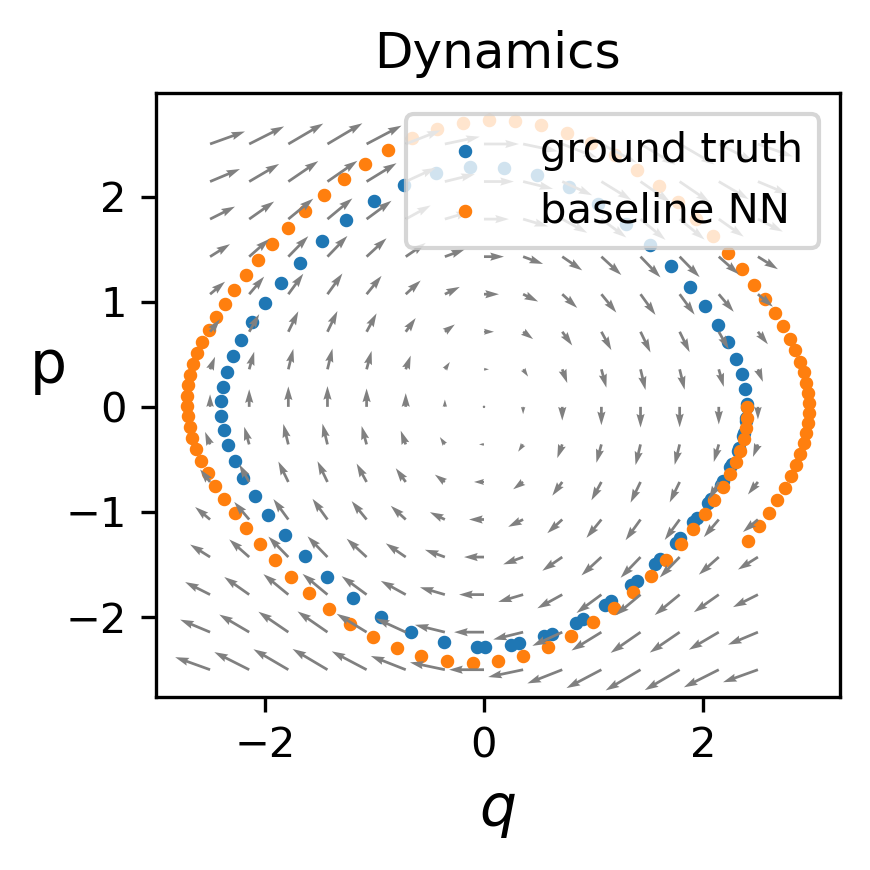

In [135]:
# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=DPI)

plt.scatter(x,y,s=5, label='ground truth')
plt.scatter(q_p_pred.T[0],q_p_pred.T[1],s=5, label='baseline NN')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("p", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')

plt.tight_layout() ; plt.show()